Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Variable Descriptions

In [2]:
# Mortgage              = Total Home Mortgage Balance Amount  
# Card Utilization      = Ratio of Credit Card balances to max limit 
# Amount Past Due       = Total Amount Past Due 

# Card Balance          = Overall Credit Card balances in current month 
# Card Balance_nm       = Overall Credit Card balances in the last n months

# Credit Inquiry        = Total number of inquiries made in current month
# Credit Inquiry_nm     = Total number of inquiries made in the last n months

# Open Trade*           = Total number of open trades presently satisfactory reported in current 
#                           month and trades are opened 12 months or older 
# Open Trade_nm         = Total number of open trades presently satisfactory reported in the last n 
#                           months and trades are opened 12 months or older 


# Delinquency Status    = Total number of trades ever derogatory including collections 
#                           (excluding satisfied medical collections) 
# Delinquency Status_nm = Total number of trades ever derogatory including collections (excluding 
#                           satisfied medical collections) in the last n months

# DDA Balance_9m        = Minimum DDA Balances with XYZ bank in last 9 months 
#                           DDA stands for Demand Deposit Accounts such as checking and saving accounts 

# Gender                = 1 if gender is Male and 0 else
# Race                  = 1 if race is White and 0 else
# Race Category         = Race by category 

# Status                = 1 Never delinquent or at most 29 consecutive days 
#                           past due in the last 24 months and 0 else

# WE HAVE NUMERIC, LAGGED NUMERIC, AND DEMOGRAPHIC DATA TO PERFORM BINARY CLASSIFICATION

EDA

In [3]:
data_dir = '../data'
raw, processed = 'raw', 'processed'

train_fname = 'train_PresSE_SRF_747.csv'

train = pd.read_csv(f'{data_dir}/{processed}/{train_fname}')

In [4]:
train.dtypes

Mortgage                  float64
Card Utilization          float64
Card Balance              float64
Card Balance_3m           float64
Card Balance_6m           float64
Card Balance_12m          float64
Amount Past Due           float64
Delinquency Status          int64
Credit Inquiry              int64
Open Trade                  int64
Credit Inquiry_3m           int64
Open Trade_3m               int64
Credit Inquiry_6m           int64
Open Trade_6m               int64
Credit Inquiry_12m          int64
Open Trade_12m              int64
Delinquency Status_3m       int64
Delinquency Status_6m       int64
Delinquency Status_12m      int64
DDA Balance_9m            float64
Gender                      int64
Race                        int64
Status                      int64
Race_Category              object
dtype: object

In [5]:
train['Race_Category'].value_counts()

Race_Category
White       9088
Hispanic    6002
Black       2872
Asian       1080
Unknown      958
Name: count, dtype: int64

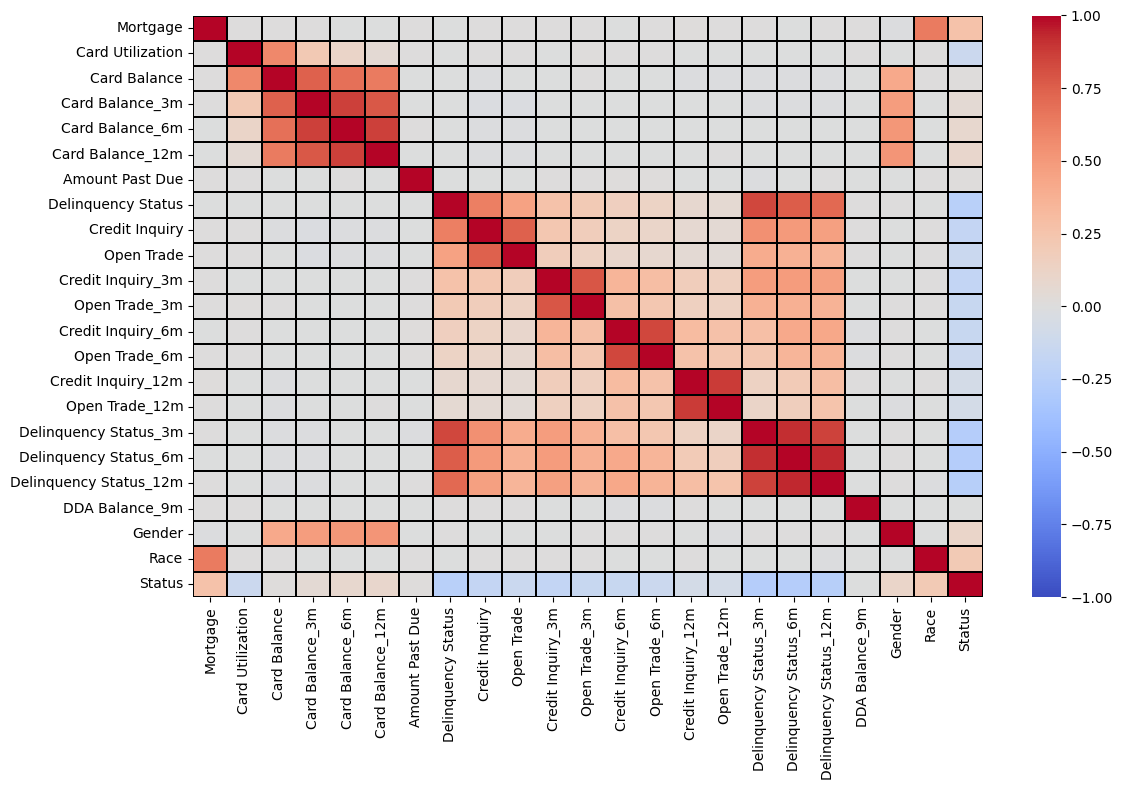

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap( train.drop('Race_Category', axis=1).corr(), cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.01, linecolor='black', ax=ax )

plt.tight_layout()
plt.show()

In [7]:
# Status (1, good) somewhat anticorrelated with:
#   Delinquency Status, Credit Inquiry, Open Trade (+ respective lags), Card Utilization

# Status (1, good) somewhat correlated with:
#   Race, Gender, Card Balance, Mortgage

# Interactions:
#   Race + Mortgage
#   Gender + Card Balance
#   Delinquency Status + Credit Inquiry + Open Trade (+ respective lags)
#   Card Balance + Card Utilization

# REMEMBER THAT LAGGED TERMS (Card Balance, Delinquency Status, Open Trade, Credit Inquiry) ARE AUTO-CORRELATED!

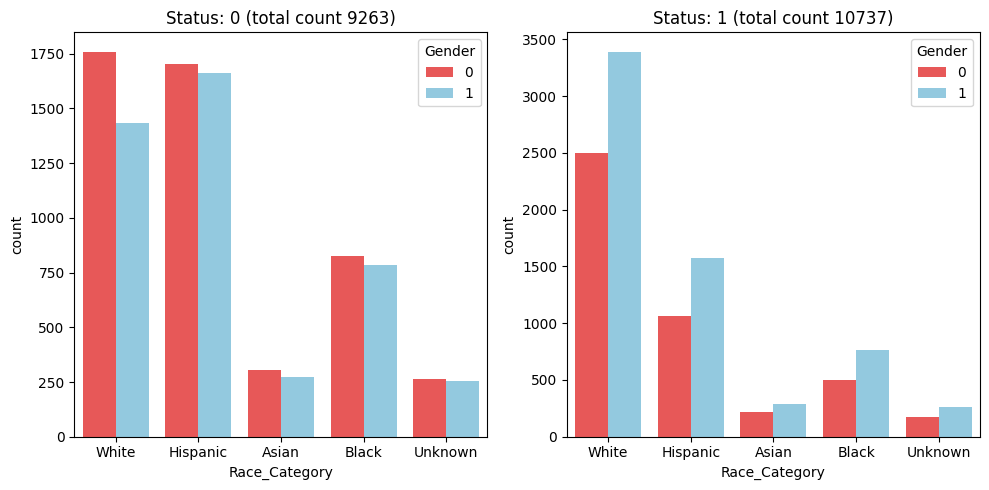

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for (i, g), ax in zip(train.groupby('Status'), axes.flatten()):
    sns.countplot(g, x='Race_Category', hue='Gender', palette=['#ff4040', '#87CEEB'], ax=ax)
    ax.set_title(f'Status: {i} (total count {len(g)})')

plt.tight_layout()
plt.show()

In [9]:
# Seems that the target labels are approximately evenly balanced.
# There is a bit of a gender imbalance in the sample of people with status label 1 (males over-represented in all race categories).

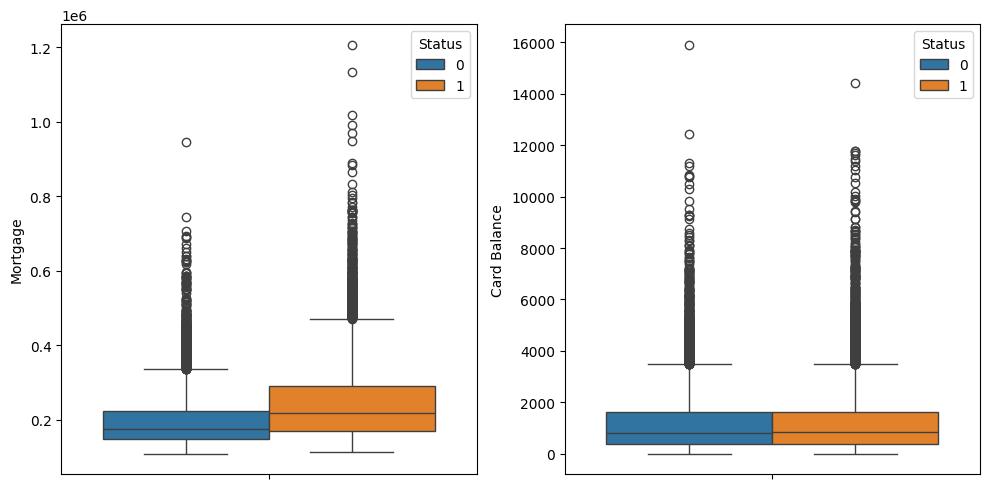

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(train, y='Mortgage', hue='Status', ax=ax[0])
sns.boxplot(train, y='Card Balance', hue='Status', ax=ax[1])

plt.tight_layout()
plt.show()

In [49]:
# Higher mortgage may be a proxy for wealth and thus impact credit status.
# A high card balance may also be a proxy for wealth. On the other hand, it can mean that a person is struggling to make payments.

In [59]:
# train[ ['Card Balance_12m', 'Card Balance_6m', 'Card Balance_3m', 'Card Balance'] ]
# train[ ['Credit Inquiry_12m', 'Credit Inquiry_6m', 'Credit Inquiry_3m', 'Credit Inquiry'] ]
# train[ ['Delinquency Status_12m', 'Delinquency Status_6m', 'Delinquency Status_3m', 'Delinquency Status'] ]
# train[ ['Open Trade_12m', 'Open Trade_6m', 'Open Trade_3m', 'Open Trade'] ]

def compute_trend(row, lagged_var_name):
    '''Checking if lags of a given variable for a given row (sample) 
    are decreasing and/or staying the same over time (versus increasing).'''
    
    curr_val = row[lagged_var_name]
    
    for lag in ('3', '6', '12'):
        col_name = f'{lagged_var_name}_{lag}m'
        prior_val = row[col_name]
        if prior_val < curr_val:
            # prior value was smaller, meaning there is an increase!
            return False
        curr_val = prior_val
    # did the lagged variable decrease (or at least stay the same)?
    return True

for col_name in ('Card Balance', 'Credit Inquiry', 'Open Trade'):
    train[f'{col_name}_Decreasing'] = train.apply(compute_trend, axis=1, lagged_var_name=col_name)

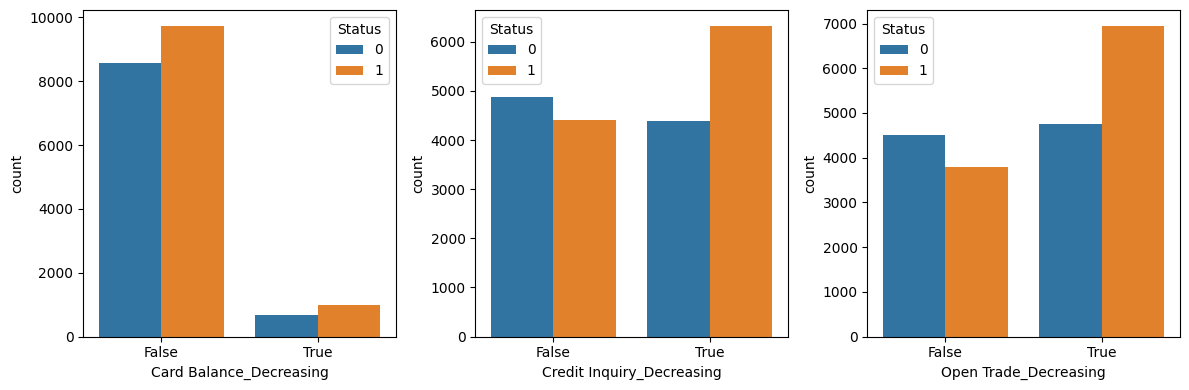

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for col_name, ax in zip(('Card Balance', 'Credit Inquiry', 'Open Trade'), axes.flatten()):
    sns.countplot(train, x=f'{col_name}_Decreasing', hue='Status', ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# If there are fewer credit inquiries as well as accounts over time, perhaps a customer's financial situation is improving.
# However, if they are closing out their accounts, there is less of a chance to be delinquent (status of zero).